## 马尔科夫链蒙特卡洛算法

前面的实验，我们都故意跳过了 PyMC 中模型训练的机理分析，只是概括的说了模型训练运用到的是马尔科夫链蒙特卡洛（MCMC）算法，因为它确实有点难。但是只要学习贝叶斯推断，我们就必须学习 MCMC。了解 MCMC 的过程，能够让我们熟悉我们建立的模型是否收敛，也能够让我们明白为何要把上千个后验样本作为解。

- 贝叶斯景象图
- MCMC 算法
- 无监督聚类
- 收敛性的优化
- 函数的自相关
- PyMC画图工具

### 贝叶斯景象图

对于一个含有 $N$ 个未知元素的贝叶斯推断问题，我们隐式地为其先验分布创建了一个 $N$ 维空间。先验分布上某一点的概率，将投射到某个高维的面或曲线上，其形状由先验分布决定。

比如，假定有两个未知元素 $p_1$、$p_2$ ，其先验分布都是（0,5）上的均匀分布，那么先验分布就存在于一个边长为 5 的正方形空间。而其概率面就是正方形上方的一个平面（由于假定了均匀分布，因此每一点概率相同）。或许，你还是有点懵，现在让我们画出图像，你就可以明白了。

Text(0.5, 0.92, 'Uniform prior landscape; alternate view')

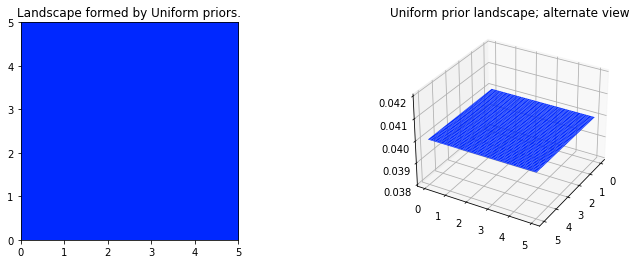

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
%matplotlib inline

figsize(12.5, 4)


jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view")

如上图所示，我们把 2 维空间里的两个参数（$p_1$、$p_2$），映射到了三维空间（概率面，即第三个维度为概率取值）中，形成一个平面。那么，为什么映射到 3 维之后还是一个平面呢？因为这两个参数都遵从相同范围的均匀分布。即选取 $(P_1,P_2)=(m,n)$ 的概率为 $0.5$，其中 $m,n$ 可以为任意值。 

现在，让我们换一个例子。如果 （$p_1$、$p_2$） 的先验分布分别为 $Exp(3)$ 和 $Exp(10)$ 的指数分布，那么对应的空间便是二维平面范围，即各维都取正值所确定的范围。而对应的三维概率面的形状则是一个从 (0,0) 点向正值方向流淌的瀑布。

Text(0.5, 0.92, '$Exp(3), Exp(10)$ prior landscape; \nalternate view')

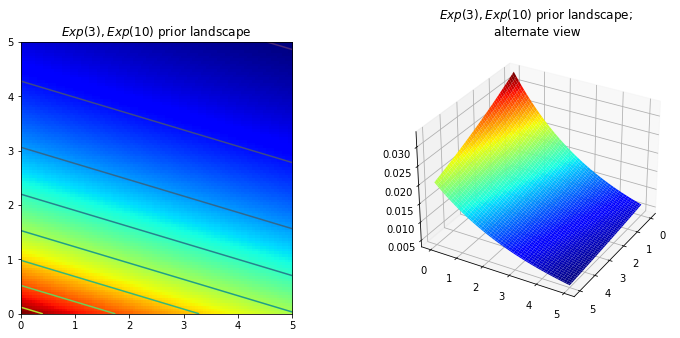

In [3]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")

In [5]:
data= [115.85679142, 152.26153716, 178.87449059, 162.93500815,
       107.02820697, 105.19141146, 118.38288501, 125.3769803 ,
       102.88054011, 206.71326136, 139.36891127, 155.41048088,
       148.75930718,  83.75957653, 139.90775261, 120.62238937,
       135.56532942, 104.88725553, 110.00788895, 118.85137336,
       113.20733624, 101.46423711,  53.56401814,  83.43273494,
       158.30503491, 106.41998007, 155.82440337, 113.19883929,
       126.7707053 , 137.37883024, 120.69539319, 111.57463629,
       115.44676987,  99.23198976, 131.64722575,  99.9637702 ,
       111.42138741, 124.69059125, 139.14509283, 136.15142861,
       130.71149604,  80.81320412, 107.82135812, 126.25964515,
       171.27426625, 157.01004439,  85.70544719, 113.57179291,
       137.0765433 ,  79.90858139,  47.40688607,  67.01135246,
       131.62129015, 132.71802234, 168.50936298, 133.76989929,
       175.54858317, 165.52423638, 126.84718209, 167.60157117,
       145.58985118, 195.61601842, 118.22246256,  89.25085984,
       128.62692372,  99.46176932, 157.10611884, 100.25011342,
       117.87364258,  94.22954036,  96.32336368, 130.97711088,
       118.13916673,  87.1847389 , 146.73637295, 125.79949606,
       103.47232693, 111.74773196, 134.65702639, 110.4112269 ,
       124.02796494,  90.58614098, 174.35292415, 145.47354447,
       120.07743569,  76.84825812, 132.76156275,  92.36097069,
        95.52784968, 133.27768821, 147.35348466, 102.01062912,
        96.50714482,  71.39916441, 140.19923169,  95.16569029,
       141.98342497, 106.60322957, 150.20777028, 170.89142074,
       129.96567389, 113.55077063, 185.35540683,  90.2195692 ,
        69.68136186,  90.37055158, 133.29291222, 143.88959719,
       199.96861265,  73.47125661, 172.43870177, 173.92219819,
       160.46825973,  55.68169798, 158.52002867, 104.0052092 ,
       106.32863344, 162.60480953,  79.11796632, 130.74270486,
       205.7499231 , 196.82723599, 188.14428208, 209.9549294 ,
       199.86619465, 211.84407566, 160.63779182, 234.54952273,
       197.98702029, 176.7565653 , 239.20325624, 220.36348666,
       218.6204437 , 195.82926041, 176.35362312, 172.00999901,
       227.61111458, 203.1618191 , 220.33946204, 174.89517485,
       224.64671154, 206.32623811, 224.35756625, 178.444173  ,
       206.22860038, 177.57079445, 215.51437633, 177.34795413,
       181.23934849, 201.64106641, 145.71789631, 181.11587272,
       169.88150482, 198.05266575, 223.79265076, 204.16012829,
       219.09764233, 154.98039516, 228.73201849, 179.50896382,
       214.77492768, 192.92926053, 197.80326952, 195.26223255,
       194.74110746, 191.22932687, 200.36835401, 223.73435432,
       216.79619004, 203.71514969, 189.35509867, 186.95434116,
       183.58084418, 197.07095828, 183.94831991, 189.73485237,
       207.05614608, 189.54524417, 198.8034028 , 222.21049957,
       198.28841825, 230.17938021, 208.37519592, 207.2072807 ,
       211.75545269, 223.99129162, 157.73046627, 202.90464479,
       212.37484002, 225.60382991, 160.4587483 , 212.61424935,
       186.57783216, 187.8548633 , 193.68292992, 200.82578696,
       211.40540966, 222.49423605, 216.32031707, 219.60776091,
       196.59734229, 226.06300698, 217.5726737 , 189.47212712,
       188.04194124, 205.53494505, 200.12115416, 170.19798234,
       181.44178685, 217.08181578, 204.33904492, 214.29398354,
       208.81573372, 236.41662356, 175.85519256, 218.98189501,
       160.82469527, 217.33975714, 204.80431949, 179.54631323,
       184.84746699, 277.60358479, 197.96521953, 175.17100827,
       179.16482989, 241.34632789, 210.95721031, 237.75939251,
       164.6185403 , 201.73020468, 227.01422405, 205.35004224,
       178.19802891, 181.32987871, 186.12733763, 194.83078571,
       213.8709249 , 227.30938346, 193.71841804, 197.3234244 ,
       177.32747444, 233.14994628, 181.36477264, 216.49529734,
       206.8273352 , 190.74177964, 160.18694497, 235.95287346,
       214.27966288, 222.09497912, 198.69703448, 198.49941344,
       201.65729836, 204.50027061, 215.2174653 , 198.79221442,
       224.16481595, 220.54835461, 155.81594844, 167.64956179,
       185.01868388, 246.41457862, 248.64093971, 176.75154878,
       186.91178046, 187.08106356, 195.83524097, 161.45416797,
       182.02101265, 219.94735798, 213.34447988, 209.05510175,
       204.61566732, 199.29169108, 194.63616535, 242.13746353,
       211.00079273, 166.27657154, 194.91432986, 187.57717597,
       221.91499562, 187.67477179, 197.18503329, 148.21405896,
       206.4803609 , 213.46412909, 191.95181474, 180.04659163,
       220.37913801, 222.35612485, 227.8082047 , 218.16858816,
       186.37622498, 177.51929197, 176.47034386, 231.57491588,
       217.16883407, 242.31966854, 196.39902968, 222.81906732]

### MCMC解决无监督问题

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


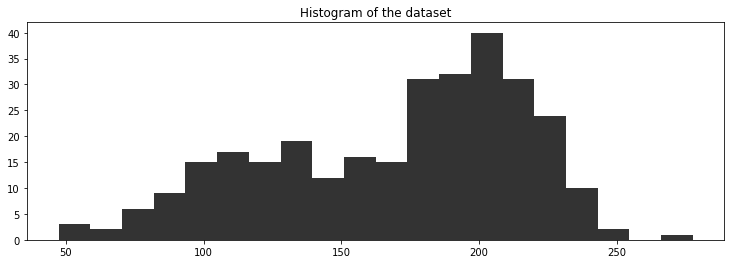

In [6]:
figsize(12.5, 4)
# 加载数据
data = np.array(data)

# 根据数据画出频率分布图
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])
print(data[:10], "...")

1. 定义：第一个簇里的数据是由参数为 $(\mu_0,\sigma_0)$ 的正态分布 $Nor_0$ 所产生的， 第二个簇里的数据是由参数为 $(\mu_1,\sigma_1)$ 的正态分布  $Nor_1$ 所产生的。
2. 定义：生成数据为第一个簇的概率为 $p$ , 第二个簇的概率为 $1-p$。 
3. 随机初始化一个概率 $p_i$。

   a. 当 $p_i$ < $p$ 时，第 i 条数据由服从于 $(\mu_0,\sigma_0)$ 的正态分布产生。
   
   b. 当 $p_i$ >= $p$ 时，第 i 条数据由服从于 $(\mu_1,\sigma_1)$ 的正态分布产生。
4. i++,并跳转到步骤 3 。如此循环直至产生了规定数目的数据。

In [7]:
import pymc3 as pm

with pm.Model() as model:
    # p1 服从均匀分布
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
print(" p1 的先验概率 = %.2f:" % p1.tag.test_value)

/Users/hui/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/hui/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


 p1 的先验概率 = 0.50:


In [8]:
import theano.tensor as T
with model:
    # 将p1，p2 拼起来
    p = T.stack([p1, p2])
    # 参数 shape 表示我们定义的变量是一个列表，它一共存了 data.shape[0] 个数据
    assignment = pm.Categorical("assignment", p,
                                shape=data.shape[0],  # 产生数据的个数
                                testval=np.random.randint(0, 2, data.shape[0]))  # testval 随机变量的初始值
# 根据概率，随机 10 个变量，观察初始化结果
# p1 的概率产生数字 0
# 1-p1 的概率产生数字 1
print(assignment.tag.test_value[:10])

[1 0 1 1 0 1 1 1 0 1]


In [9]:
with model:
    # 采用变量数组的方式，sagma0 和 sagma1 都存入变量 sds 中
    sds = pm.Uniform("sds", 0, 100, shape=2)
    # 这里其实是这是数据产生模型所需要的 mu1 mu2
    # 而mu1 mu2 又是有一个新的正态分布函数产生
    # 因为直接设置为120 或者190 的话，太过武断
    # 并且这两个参数又存在一定的取值倾向，一个倾向于120，一个倾向于190
    # 因此，选择他们服从正态分布
    centers = pm.Normal("centers",
                        mu=np.array([120, 190]),
                        sd=np.array([10, 10]),
                        shape=2)  # 还是一次性定义两个变量
model

In [10]:
with model:
    # 根据选择的结果，得到每条数据应该具有的分布函数参数
    # 即选择参数是 （mu1,sagma1） 还是 (mu2,sigam2)
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])

    # 将参数传入最终模型，所有的数据都是通过该模型产生的
    # observed=data：将真实数据传入我们定义的模型中
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)

print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [1 0 1 1] ...
Assigned center:  [190. 120. 190. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


In [11]:
with model:
    # 告诉模型这些参数为连续型变量"
    step1 = pm.Metropolis(vars=[p, sds, centers])
    # 告诉模型，类别是一个离散型变量
    step2 = pm.ElemwiseCategorical(vars=[assignment])
model

/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  """


In [12]:
with model:
     # 这里表示我们需要返回 5000 个样本，来描述我们的后验分布
    trace = pm.sample(5000, step=[step1, step2])

/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 65 seconds.
/Users/hui/anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


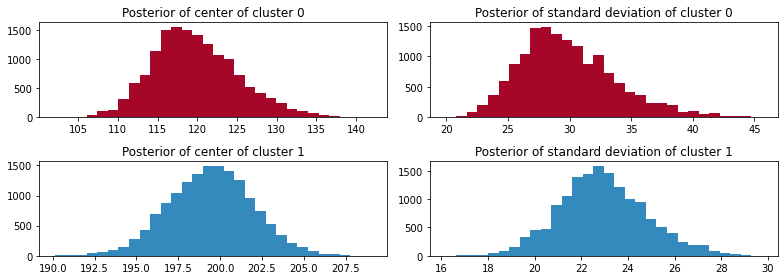

In [13]:
figsize(11.0, 4)
# 获得参数的迹，即 5000 个样本
std_trace = trace["sds"][5000:]
center_trace = trace["centers"][5000:]
# 设置画图的颜色
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

plt.tight_layout()

In [14]:
print(data.shape)
print(trace["assignment"].shape)

(300,)
(20000, 300)


In [15]:
trace["assignment"][1, :]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Text(0.5, 1.0, 'Posterior labels of data points')

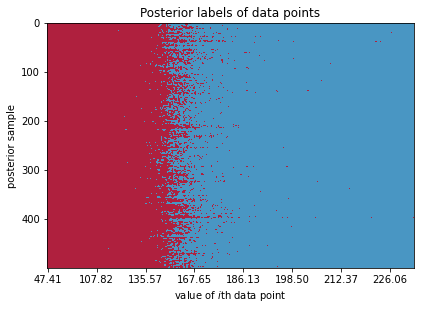

In [16]:
import matplotlib as mpl
figsize(12.5, 4.5)
# 设置颜色组
plt.cmap = mpl.colors.ListedColormap(colors)
# 每间隔40个估计取一次样，且每次取出来之后，把列按照 data 顺序进行重排
plt.imshow(trace["assignment"][::40, np.argsort(data)],
           cmap=plt.cmap, aspect=.4, alpha=.9)

# 画出图片
plt.xticks(np.arange(0, data.shape[0], 40),
           ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points")

Text(0.5, 0, 'value of data point')

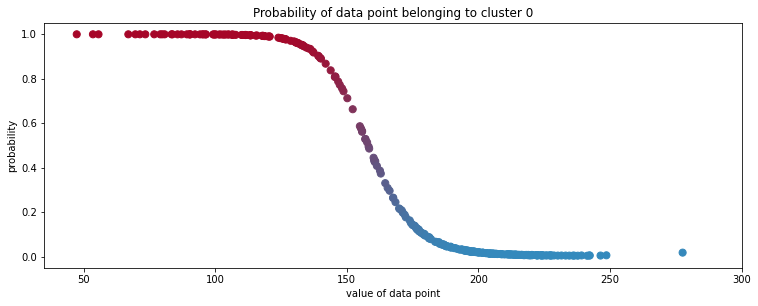

In [17]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
            c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point")

Text(0.5, 1.0, 'Visualizing Clusters using posterior-mean parameters')

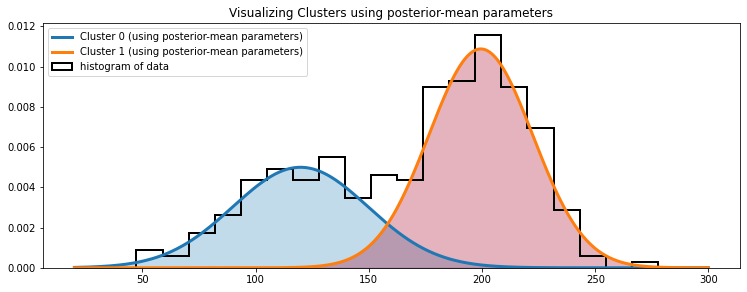

In [19]:
norm = stats.norm
x = np.linspace(20, 300, 500)

# 获得模型参数结果的平均
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

# 画出真实数据的频率图
plt.hist(data, bins=20, histtype="step", density=True, color="k",
         lw=2, label="histogram of data")

# 画出第一个模型  的分布函数 Nor0
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

# 画出第二个模型 的分布函数 Nor1
y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

#### 从聚类到预测

解决这个预测问题有两种思路。最朴素的方法就是把新的数据放入数据集合中，然后重新执行整个 MCMC 过程。并通过结果，判断新的观测数据所属类别。但是这样做有一个很大的缺点就是耗时。每当来一个新的数据，我们就需要重新运行整个训练过程，这显然不是一个好的想法。

In [20]:
# 定义正态函数
norm_pdf = stats.norm.pdf
# 获得样本中的 p 后验概率
# 这个p其实就是式子中的 P( L_x = 0 )
p_trace_0 = trace["p"][25000:]
x = 175
# 计算 P( x=175  | L_x = 0  )P( L_x = 0 ):当 x 是第一类时，x =175的概率。
# 因此需要带入参数 center_0 和 sigam_0
p_x_l_0 = norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0])

# P( x=175  | L_x = 1  )
p_trace_1 = 1 - p_trace_0
# 计算 P( x=175  | L_x = 0  )P( L_x = 0 ):当 x 是第一类时，x =175的概率。
# 因此需要带入参数 center_1 和 sigam_1
p_x_l_1 = norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

# 取所有样本结果的平均。当结果大于0.5表示，超过一半的样本显示 x 属于类别 0
# 若小于0.4,表示，超过一半的样本显示 x 属于 类别 1
v = p_x_l_0 > p_x_l_1

print("Probability of belonging to cluster 0:", v.mean())

Probability of belonging to cluster 0: 0.0031333333333333335


#### 使用 MAP 来改进收敛性

从统计学的角度分析，只要 MCMC 能够训练足够长的时间，就可以忽略起始位置，我们把这种特性叫做 MCMC 的收敛性。因而，如果我们看到不同的后验分析结果，那就可能是因为 MCMC 还没有充分收敛。


实际上。正确的起始位置不仅可以提升收敛速度，还可以提高准确性。理想情况下，我们希望起始位置就在分布图形的山峰处，其实就是后验分布所在的区域。如果我们以这个区域中的某一点为起始点，我们就可以避免很长的预热期以及错误的估计结果。通常，我们将山峰所在位置称为 最大后验，简称为 MAP。

当然 MAP 的真实位置时位置的，但是 PyMC 为我们提供了一个用于估计该位置的对象：PyMC 主命名空间下的 MAP 对象。该对象由 `pm.find_MAP()` 函数定义。我们只需要把 初始化的位置 加入训练函数中即可。代码如下：

In [21]:
with model:
    # 找到较好的山峰
    start = pm.find_MAP()
    # 利用 MCMC 进行模型训练且指定初始位置
    trace = pm.sample(5000, step=[step1, step2], start=start)
# 输出分类矩阵的大小
trace["assignment"].shape

/Users/hui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/Users/hui/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 109 seconds.
/Users/hui/anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


(20000, 300)

In [22]:
# 原来是要去 trace["assignment"] 作为估计的
# 现在我们只需要取后一半的样本作为后验分布的估计即可
trace["assignment"][2500:]

array([[0, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1]])


## 实验总结

本实验主要介绍了贝叶斯推断返回的后验分布是无数个样本的原因，然后利用贝叶斯推断完成了混合模型的无监督聚类，接下来，讨论了如何提高 MCMC 算法的收敛速度。最后，介绍了一种 PyMC 中自带画图工具。下一个实验，我们将继续介绍 MCMC 中的一些小技巧。